<a href="https://colab.research.google.com/github/safeliquids/notebooks-for-NES2-2024/blob/cv-05/lecture_05/binary_classification_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification example - classifying movie reviews from the IMDB dataset


Based on: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb

IMDB Dataset is a dataset for binary sentiment classification (positive or negative reviews). It contains a set of 25,000 highly polar movie reviews for training and 25,000 for testing.
http://ai.stanford.edu/~amaas/data/sentiment/
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews




In [7]:
import keras

# Load the IMDB dataset
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10_000) # 10000 most common words



Observe the data:

In [3]:
import numpy as np

# 25000 training samples - movie reviews.
print(train_data.shape, train_labels.shape)

# 25000 testing samples - movie reviews.
print(test_data.shape, test_labels.shape)

# 2 categories: positive / negative sentinent
print(train_labels[:10])

print(train_data[0])

# 10000 most common words
dimension = max([max(sequence) for sequence in train_data])+1
print(dimension)

# Distribution of training and testing labels
print("Training Label distribution:", np.bincount(train_labels))
print("Testing Label distribution:", np.bincount(test_labels))



(25000,) (25000,)
(25000,) (25000,)
[1 0 0 1 0 0 1 0 1 0]
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
10

Example of a review in the training data:

In [3]:
# Get the word index from the IMDB dataset.
# This is a dictionary mapping words to integers.
word_index = imdb.get_word_index()

# Create a reverse word index, mapping integers back to words.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode the first review in the training data.
# Subtract 3 from each index to account for special tokens (padding, start of sequence, unknown).
# Replace any unknown words with '?'.
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

# Print the decoded review.
print(decoded_review)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should

# Preprocess the data

In [4]:
# 1. Vectorize the data
def vectorize_sequences(sequences):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

x_train_ext = vectorize_sequences(train_data)  # Vectorize training data
x_test = vectorize_sequences(test_data)    # Vectorize testing data

y_train_ext = np.asarray(train_labels).astype('float32')  # Vectorize training labels
y_test = np.asarray(test_labels).astype('float32')    # Vectorize testing labels


# 2. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.
x_val = x_train_ext[:10000]
x_train = x_train_ext[10000:]
y_val = y_train_ext[:10000]
y_train = y_train_ext[10000:]
y_train = y_train.reshape(-1, 1)  # Reshape to match output shape
y_val = y_val.reshape(-1, 1)      # Reshape to match output shape
y_test = y_test.reshape(-1, 1)      # Reshape to match output shape


print(x_train[0], x_train.shape, y_train[0])

[0. 1. 1. ... 0. 0. 0.] (15000, 10000) [0.]


# Define and train the model

### MLP model for binary classification:
- 'sigmoid' activation function in the output layer
- 'relu' or 'tanh' in the hidden layers
- BinaryCrossentropy (or MSE) loss function + BinaryAccuracy metrics (https://keras.io/api/metrics)

In [5]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "imdb_mlp_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_imdb/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


# define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(shape=(10000,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # output layer
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss= keras.losses.BinaryCrossentropy(),
              metrics= [keras.metrics.BinaryAccuracy("accuracy")])


num_epochs = 20
batch_size = 512

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

# Save the model
model_dir = "./models/"

# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# Create a unique model name using the current date and time
model_name = model_dir + model_datetime_name + ".keras"
# Save the model with the generated name
model.save(model_name)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.6002 - loss: 0.6380 - val_accuracy: 0.8524 - val_loss: 0.4590
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8903 - loss: 0.3798 - val_accuracy: 0.8841 - val_loss: 0.3159
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9279 - loss: 0.2391 - val_accuracy: 0.8858 - val_loss: 0.2887
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9473 - loss: 0.1763 - val_accuracy: 0.8888 - val_loss: 0.2770
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9641 - loss: 0.1282 - val_accuracy: 0.8868 - val_loss: 0.2861
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9763 - loss: 0.0960 - val_accuracy: 0.8850 - val_loss: 0.3050
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9861 - loss: 0.0685 - val_accuracy: 0.8800 - val_loss: 0.3329
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9920 - loss: 0.0479 - val_accuracy: 0.8797 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


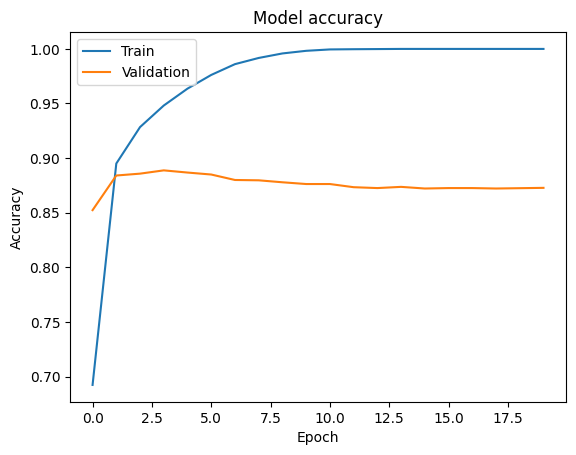

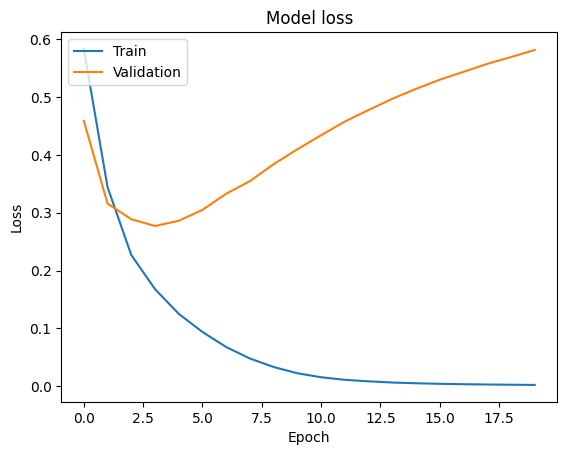

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 0.0018
Training accuracy: 0.9999333620071411 
Train loss: 0.0017803303198888898
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8724 - loss: 0.5787
Validation accuracy: 0.8727999925613403 
Val loss: 0.5816663503646851
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8580 - loss: 0.6371
Test accuracy: 0.8607199788093567 
Test loss: 0.6277482509613037


In [6]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

In [7]:

# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Find the indices of misclassified samples
misclassified_indices = np.where(y_pred != y_test)[0]

# Print the number of misclassified samples
print("Number of misclassified samples:", len(misclassified_indices))

# Print examples of misclassified samples (e.g., first 5)
num_examples_to_show = 5
for i in range(min(num_examples_to_show, len(misclassified_indices))):
    index = misclassified_indices[i]
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[index]])
    print(f"\nMisclassified Sample {i+1}:")
    print("Predicted Class:", y_pred[index][0])
    print("True Class:", y_test[index][0])
    print("Review:", decoded_review)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Number of misclassified samples: 3564

Misclassified Sample 1:
Predicted Class: 1
True Class: 0.0
Review: ? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with 

# Summary

1. For binary classification, the loss function BinaryCrossentropy is used (though MSE can also be used), and the metric is BinaryAccuracy. A sigmoid activation function is chosen for the output layer.
2. If input vectors have different lengths, they need to be adjusted to have the same length.
3. Word index is the simplest way to encode texts (but there are better approaches like TF-IDF, Word Embeddings, etc.).
4. To evaluate how well the model is learning and generalizing, a validation dataset is used.


# Exercises
1. **Change the number of epochs** to avoid overtraining. Compare the errors on the validation and the test sets.
2. **Implement early stopping** to avoid overtraining. Compare the errors.
3. **Change the number of neurons or layers.** See how this affects the accuracy of the model and the learning curves.
You can also experiment with different **activation functions**
in the hidden layers.
4. **Change the loss function**.
Try using the mse (mean squared error) loss function and compare the results.


## Exercise 1

Change the number of epochs to avoid overtraining. Compare the errors on the valiadation and test sets.

Graph above shows that validation set loss reaches minimum around the 4-th or 5-th epoch. Stopping there should lead to less over-fitting.

In [8]:
# same architecture and parameters as above
new_model = keras.Sequential([
    keras.layers.InputLayer(shape=(10000,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
new_model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    loss= keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy("accuracy")])
new_history = new_model.fit(
    x_train,
    y_train,
    epochs=4,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback])

Epoch 1/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7001 - loss: 0.6165 - val_accuracy: 0.8630 - val_loss: 0.3799
Epoch 2/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8938 - loss: 0.3127 - val_accuracy: 0.8898 - val_loss: 0.2882
Epoch 3/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9387 - loss: 0.1954 - val_accuracy: 0.8886 - val_loss: 0.2763
Epoch 4/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9579 - loss: 0.1355 - val_accuracy: 0.8833 - val_loss: 0.2905


In [5]:
def print_results(name: str, results: dict[str, float]):
    print(name)
    for label, score in results.items():
        print("\t{: <10} {:.6}".format(label, score))

In [9]:
train_results = new_model.evaluate(x_train, y_train, verbose=0, return_dict=True)
val_results = new_model.evaluate(x_val, y_val, verbose=0, return_dict=True)
test_results = new_model.evaluate(x_test, y_test, verbose=0, return_dict=True)
print_results("Training set results", train_results)
print_results("Validation set results", val_results)
print_results("Test set results", test_results)

Training set results
	accuracy   0.972933
	loss       0.105232
Validation set results
	accuracy   0.8833
	loss       0.290547
Test set results
	accuracy   0.87632
	loss       0.31433


## Exercise 2
Implement early stopping to avoid overtraining. Compare the errors.

We incrementally fit the model. (Accdg. to [this discussion](https://github.com/keras-team/keras/issues/4446) this can be done by successibe calls to `model.fit()`) Once the loss on the validation set starts increasing, stop iterating.

In [10]:
model_2 = keras.Sequential([
    keras.layers.InputLayer(shape=(10000,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[ keras.metrics.BinaryAccuracy("accuracy") ])
train_results_0 = model_2.evaluate(x_train, y_train, verbose=0, return_dict=True)
val_results_0 = model_2.evaluate(x_val, y_val, verbose=0, return_dict=True)
history_2 = {
    "accuracy": [train_results_0["accuracy"]],
    "loss": [train_results_0["loss"]],
    "val_accuracy": [val_results_0["accuracy"]],
    "val_loss": [val_results_0["loss"]]
}
names = ["accuracy", "loss", "val_accuracy", "val_loss"]
epoch_count = 0
while True and epoch_count < 20:
    epoch_count += 1
    history = model_2.fit(
        x_train, y_train, epochs=1, batch_size=batch_size,
        validation_data=(x_val, y_val))
    for na in names:
        history_2[na].append(history.history[na][0])
    if epoch_count >= 2 and history_2["val_loss"][-1] > history_2["val_loss"][-2]:
        break

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6541 - loss: 0.6433 - val_accuracy: 0.8567 - val_loss: 0.4118
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8922 - loss: 0.3315 - val_accuracy: 0.8881 - val_loss: 0.2950
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9344 - loss: 0.2084 - val_accuracy: 0.8902 - val_loss: 0.2752
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9552 - loss: 0.1492 - val_accuracy: 0.8882 - val_loss: 0.2795


In [11]:
train_results = model_2.evaluate(x_train, y_train, verbose=0, return_dict=True)
val_results = model_2.evaluate(x_val, y_val, verbose=0, return_dict=True)
test_results = model_2.evaluate(x_test, y_test, verbose=0, return_dict=True)

# of epochs: 4
Training set results
	accuracy   0.97
	loss       0.116168
Validation set results
	accuracy   0.8882
	loss       0.279454
Test set results
	accuracy   0.88024
	loss       0.29972


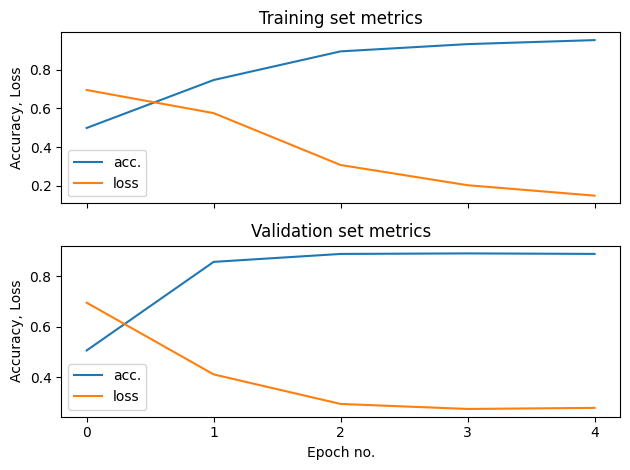

In [12]:
print("# of epochs:", epoch_count)

print_results("Training set results", train_results)
print_results("Validation set results", val_results)
print_results("Test set results", test_results)

subplot_kwords = {
    "xticks": list(range(epoch_count + 1)),
    "xlabel": "Epoch no.",
    "ylabel": "Accuracy, Loss",
    "ylim": (0, None)
}
fig, axs = plt.subplots(2, 1, subplot_kw=subplot_kwords, layout="tight", sharex=True)
axs[0].set_title("Training set metrics")
axs[0].plot(history_2["accuracy"], label="acc.")
axs[0].plot(history_2["loss"], label="loss")

axs[1].set_title("Validation set metrics")
axs[1].plot(history_2["val_accuracy"], label="acc.")
axs[1].plot(history_2["val_loss"], label="loss")

axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
# fig.tight_layout()

fig.show()

## Exercise 3

Change the number of neurons or layers. See how this affects the accuracy
of the model and the learning curves. You can also experiment with
different activation functions in the hidden layers.

In [23]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

model_3 = keras.Sequential([
    keras.layers.InputLayer(shape=(10000,)),
    keras.layers.Dense(6000, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # output layer
])

# still some problems, exponential learning rate decays too quickly,
# leading to overfitting
# Adadelta seems to be a good choice, but could try Adam or SGD again with
# different topology
lr_object = keras.optimizers.schedules.ExponentialDecay(
    0.01, 50, 0.98)
model_3.compile(
    optimizer= keras.optimizers.Adadelta(learning_rate=lr_object),
    loss= keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy("accuracy")])

num_epochs = 60
batch_size = 512

history_3 = model_3.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping])

train_results = model_3.evaluate(x_train, y_train, verbose=0, return_dict=True)
val_results = model_3.evaluate(x_val, y_val, verbose=0, return_dict=True)
test_results = model_3.evaluate(x_test, y_test, verbose=0, return_dict=True)

print_results("Training set results", train_results)
print_results("Validation set results", val_results)
print_results("Test set results", test_results)

subplot_kwords = {
    # "xticks": list(range(len(history_3.history["accuracy"]))),
    "xlabel": "Epoch no.",
    "ylabel": "Accuracy, Loss",
    "ylim": (0, None)
}


Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.5140 - loss: 0.6928 - val_accuracy: 0.5277 - val_loss: 0.6920
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5405 - loss: 0.6913 - val_accuracy: 0.5468 - val_loss: 0.6903
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5692 - loss: 0.6887 - val_accuracy: 0.5702 - val_loss: 0.6876
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6002 - loss: 0.6850 - val_accuracy: 0.6145 - val_loss: 0.6836
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6468 - loss: 0.6802 - val_accuracy: 0.6781 - val_loss: 0.6757
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6994 - loss: 0.6701 - val_accuracy: 0.7108 - val_loss: 0.6629
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7339 - loss: 0.6559 - val_accuracy: 0.7411 - val_loss: 0.6497
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7582 - loss: 0.6425 - val_accuracy: 0.7516 - 

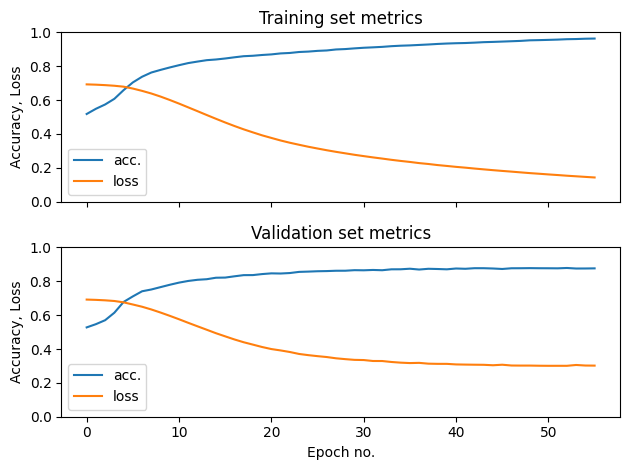

In [24]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 1, subplot_kw=subplot_kwords, layout="tight", sharex=True)
axs[0].set_title("Training set metrics")
axs[0].plot(history_3.history["accuracy"], label="acc.")
axs[0].plot(history_3.history["loss"], label="loss")

axs[1].set_title("Validation set metrics")
axs[1].plot(history_3.history["val_accuracy"], label="acc.")
axs[1].plot(history_3.history["val_loss"], label="loss")

axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
# fig.tight_layout()

fig.show()

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_imdb --reload_interval=1

Reusing TensorBoard on port 6006 (pid 19008), started 1:19:48 ago. (Use '!kill 19008' to kill it.)